# Hyperparameters Tunning for Deep Learning Models (full of errors)
TODO add description

In [1]:
import optuna 
import sys; sys.path.append('..')
from thesis_package import utils, aimodels as myai, metrics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
num_trials = 1

c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Regression
y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns=['timestamps'])
exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
train_x, valid_x, train_y, valid_y, scaler_max = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
data_max_reg = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns=['timestamps'])
train_x, valid_x, train_y, valid_y, scaler_min = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
data_min_reg = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
# Threshold
threshold_max = utils.compute_threshold(y_max_u) /scaler_max['y']
threshold_min = utils.compute_threshold(y_min_u) /scaler_min['y']
print(threshold_min)
print(threshold_max)
# Classification
y_max_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_sparse_bool_constr.csv').drop(columns=['timestamps'])
train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u_sparse_bool[utils.cols_with_positive_values(y_max_u_sparse_bool)], test_size=0.2, scaling=True)
data_max_class = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}

y_min_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_sparse_bool_constr.csv').drop(columns=['timestamps'])
train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u_sparse_bool[utils.cols_with_positive_values(y_min_u_sparse_bool)], test_size=0.2, scaling=True)
data_min_class = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}

0.06450243730741544
0.054008631153497785


# Max u

## MLP: Sparse Classification Dataset

Build optuna study...

In [3]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_max_u_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_sparse_bool_constr.csv').drop(columns='timestamps') 
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    X_max_u_bool_train, X_max_u_bool_test, y_max_u_bool_train, y_max_u_bool_test, scaler = utils.split_and_suffle(exogenous_data, y_max_u_bool[utils.cols_with_positive_values(y_max_u_bool)], test_size=0.2, scaling=True)
    data = {'X_train':X_max_u_bool_train.astype(float),
            'X_test': X_max_u_bool_test.astype(float),
            'y_train':y_max_u_bool_train.astype(float),
            'y_test': y_max_u_bool_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': True
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data_max_class)
    prediction = pd.DataFrame(prediction, columns=utils.cols_with_positive_values(y_max_u_bool))
    tp, tn, fp, fn = 0, 0, 0, 0
    for bus in prediction.columns:
        tp += sum((prediction[bus] == 1) & (data_max_class['y_test'][bus] == 1))
        tn += sum((prediction[bus] == 0) & (data_max_class['y_test'][bus] == 0))
        fp += sum((prediction[bus] == 1) & (data_max_class['y_test'][bus] == 0))
        fn += sum((prediction[bus] == 0) & (data_max_class['y_test'][bus] == 1))
    mcc_score = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return mcc_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_sparse_classifier_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,True\n")
    f.write("value,{}\n".format(trial.value))

[I 2022-10-11 18:20:46,386] A new study created in memory with name: no-name-49328e56-1e68-45df-a8e0-cf557c59270d


In [ ]:
y_max_u_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_sparse_bool_constr.csv').drop(columns='timestamps') 

In [ ]:
y_max_u_bool.columns

Index(['ext_grid', 'bus_1', 'bus_2', 'bus_3', 'bus_4', 'bus_5', 'bus_6',
       'bus_7', 'bus_8', 'bus_9', 'bus_10', 'bus_11', 'bus_12', 'bus_13',
       'bus_14', 'bus_15', 'bus_16', 'bus_19', 'bus_20', 'bus_22', 'bus_25',
       'bus_26', 'bus_28', 'bus_29', 'bus_30', 'bus_31', 'bus_17', 'bus_21',
       'bus_24', 'bus_18', 'bus_23', 'bus_27', 'bus_32', 'bus_33'],
      dtype='object')

Now we confirm that the target feature is created correctly, being in accord with the sparse dataset.

## MLP: Balanced Classification Dataset

[I 2022-10-11 16:24:21,069] A new study created in memory with name: no-name-24c9e5b0-0424-482a-a481-d79a5109dfee
[I 2022-10-11 16:24:37,184] Trial 0 finished with value: 0.00944101104864834 and parameters: {'hidden_size': 40, 'n_layers': 2, 'dropout': 0.14412693761891965, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 1.819060520991615e-05, 'epochs': 41, 'batch_size': 256}. Best is trial 0 with value: 0.00944101104864834.
[I 2022-10-11 16:24:38,412] Trial 1 finished with value: 0.10847205796348319 and parameters: {'hidden_size': 90, 'n_layers': 3, 'dropout': 0.07427090438545547, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 3.133807740932914e-05, 'epochs': 1, 'batch_size': 1024}. Best is trial 1 with value: 0.10847205796348319.
[I 2022-10-11 16:24:43,803] Trial 2 finished with value: 0.06740602646220073 and parameters: {'hidden_size': 42, 'n_layers': 2, 'dropout': 0.3155165066485207, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 0.00028334185272834816, 'epochs': 14, 'batch

Number of finished trials:  30
Best trial:
  Value: 0.22010388420204974
  Params: 
    hidden_size: 73
    n_layers: 3
    dropout: 0.36630970706248744
    activation: tanh
    optimizer: adam
    lr: 0.0036156373182309426
    epochs: 99
    batch_size: 1024


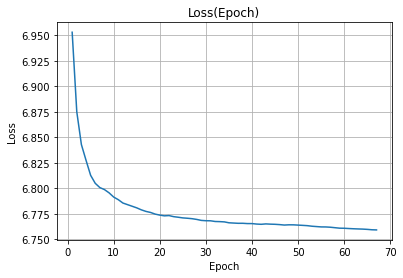

In [ ]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_max_u_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_balanced_bool_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_balanced.csv').drop(columns=['date'])
    X_max_u_bool_train, X_max_u_bool_test, y_max_u_bool_train, y_max_u_bool_test, scaler = utils.split_and_suffle(exogenous_data, y_max_u_bool[utils.cols_with_positive_values(y_max_u_bool)], test_size=0.2, scaling=True)
    data = {'X_train':X_max_u_bool_train.astype(float),
            'X_test': X_max_u_bool_test.astype(float),
            'y_train':y_max_u_bool_train.astype(float),
            'y_test': y_max_u_bool_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': True
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data_max_class)
    prediction = pd.DataFrame(prediction, columns=utils.cols_with_positive_values(y_max_u_bool))
    tp, tn, fp, fn = 0, 0, 0, 0
    for bus in prediction.columns:
        tp += sum((prediction[bus] == 1) & (data_max_class['y_test'][bus] == 1))
        tn += sum((prediction[bus] == 0) & (data_max_class['y_test'][bus] == 0))
        fp += sum((prediction[bus] == 1) & (data_max_class['y_test'][bus] == 0))
        fn += sum((prediction[bus] == 0) & (data_max_class['y_test'][bus] == 1))
    mcc_score = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return mcc_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_balanced_classifier_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,True\n")
    f.write("value,{}\n".format(trial.value))

## MLP: Regression Sparse Dataset

[I 2022-10-11 16:46:04,727] A new study created in memory with name: no-name-861d547a-a5d6-481e-a1b6-2e00e56827b5
[I 2022-10-11 16:53:39,602] Trial 0 finished with value: 0.07815896912224726 and parameters: {'hidden_size': 92, 'n_layers': 2, 'dropout': 0.45738500076983574, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 2.2066463773561474e-05, 'epochs': 91, 'batch_size': 256}. Best is trial 0 with value: 0.07815896912224726.
[I 2022-10-11 16:55:51,250] Trial 1 finished with value: 0.2212261821318649 and parameters: {'hidden_size': 3, 'n_layers': 1, 'dropout': 0.24911998177095773, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.0612145088504517, 'epochs': 39, 'batch_size': 1024}. Best is trial 1 with value: 0.2212261821318649.
[I 2022-10-11 16:58:16,311] Trial 2 finished with value: 0.1685535252339578 and parameters: {'hidden_size': 27, 'n_layers': 2, 'dropout': 0.14468469591768274, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.00020216788979212136, 'epochs': 30, 'batch_size'

KeyboardInterrupt: 

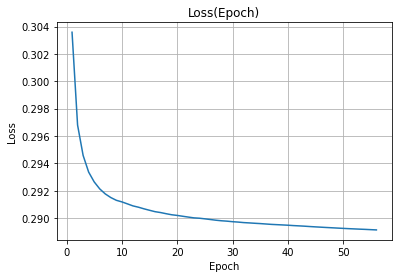

In [ ]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns='timestamps')
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    X_max_u_train, X_max_u_test, y_max_u_train, y_max_u_test, scaler = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
    data = {'X_train':X_max_u_train.astype(float),
            'X_test': X_max_u_test.astype(float),
            'y_train':y_max_u_train.astype(float),
            'y_test': y_max_u_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': False
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data_max_reg)
    prediction = pd.DataFrame(prediction, columns=y_max_u.columns)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_max_reg['y_test'], threshold=threshold_max)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_regression_sparse_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,False\n")
    f.write("value,{}\n".format(trial.value))

## MLP: Regression Focused Dataset

In [ ]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_focused_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_focused.csv').drop(columns=['date'])
    X_max_u_train, X_max_u_test, y_max_u_train, y_max_u_test, scaler = utils.split_and_suffle(exogenous_data, y_max_u, scaling=True)
    data = {'X_train':X_max_u_train.astype(float),
            'X_test': X_max_u_test.astype(float),
            'y_train':y_max_u_train.astype(float),
            'y_test': y_max_u_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': False
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    # print(model.strategy.model.eval())
    prediction = model.predict(data_max_reg)
    prediction = pd.DataFrame(prediction, columns=y_max_u.columns)
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_max_reg['y_test'], threshold=threshold_max)
    return metric.hybrid_mcc
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_regression_focused_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,False\n")
    f.write("value,{}\n".format(trial.value))

## MLP: Regression Filtered Dataset

In [ ]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns='timestamps')
    y_max_u = y_max_u[utils.cols_with_positive_values(y_max_u)]
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    X_max_u_train, X_max_u_test, y_max_u_train, y_max_u_test, scaler = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
    data = {'X_train':X_max_u_train.astype(float),
            'X_test': X_max_u_test.astype(float),
            'y_train':y_max_u_train.astype(float),
            'y_test': y_max_u_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': False
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data_max_reg)
    prediction = pd.DataFrame(prediction, columns=y_max_u.columns)
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_max_reg['y_test'][prediction.columns], threshold=threshold_max)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_regression_filtered_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,False\n")
    f.write("value,{}\n".format(trial.value))

# Min u

## MLP: Sparse Classification Dataset

In [ ]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_min_u_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_sparse_bool_constr.csv').drop(columns='timestamps')
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    X_min_u_bool_train, X_min_u_bool_test, y_min_u_bool_train, y_min_u_bool_test, scaler = utils.split_and_suffle(exogenous_data, y_min_u_bool[utils.cols_with_positive_values(y_min_u_bool)], test_size=0.2, scaling=True)
    data = {'X_train':X_min_u_bool_train.astype(float),
            'X_test': X_min_u_bool_test.astype(float),
            'y_train':y_min_u_bool_train.astype(float),
            'y_test': y_min_u_bool_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': True
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data_min_class)       
    prediction = pd.DataFrame(prediction, columns=utils.cols_with_positive_values(y_min_u_bool))
    tp, tn, fp, fn = 0, 0, 0, 0
    for bus in prediction.columns:
        tp += sum((prediction[bus] == 1) & (data_min_class['y_test'][bus] == 1))
        tn += sum((prediction[bus] == 0) & (data_min_class['y_test'][bus] == 0))
        fp += sum((prediction[bus] == 1) & (data_min_class['y_test'][bus] == 0))
        fn += sum((prediction[bus] == 0) & (data_min_class['y_test'][bus] == 1))
    mcc_score = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return mcc_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_sparse_classifier_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,True\n")
    f.write("value,{}\n".format(trial.value))

## MLP: Balanced Classification Dataset

In [ ]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_min_u_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_balanced_bool_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_balanced.csv').drop(columns=['date'])
    X_max_u_bool_train, X_max_u_bool_test, y_max_u_bool_train, y_max_u_bool_test, scaler = utils.split_and_suffle(exogenous_data, y_min_u_bool[utils.cols_with_positive_values(y_min_u_bool)], test_size=0.2, scaling=True)
    data = {'X_train':X_max_u_bool_train.astype(float),
            'X_test': X_max_u_bool_test.astype(float),
            'y_train':y_max_u_bool_train.astype(float),
            'y_test': y_max_u_bool_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': True
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data_min_class)
    prediction = pd.DataFrame(prediction, columns=utils.cols_with_positive_values(y_min_u_bool))
    tp, tn, fp, fn = 0, 0, 0, 0
    for bus in prediction.columns:
        tp += sum((prediction[bus] == 1) & (data_min_class['y_test'][bus] == 1))
        tn += sum((prediction[bus] == 0) & (data_min_class['y_test'][bus] == 0))
        fp += sum((prediction[bus] == 1) & (data_min_class['y_test'][bus] == 0))
        fn += sum((prediction[bus] == 0) & (data_min_class['y_test'][bus] == 1))
    mcc_score = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return mcc_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_balanced_classifier_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,True\n")
    f.write("value,{}\n".format(trial.value))

## MLP: Regression Sparse Dataset

In [ ]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns='timestamps')
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    X_min_u_train, X_min_u_test, y_min_u_train, y_min_u_test, scaler = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
    data = {'X_train':X_min_u_train.astype(float),
            'X_test': X_min_u_test.astype(float),
            'y_train':y_min_u_train.astype(float),
            'y_test': y_min_u_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': False
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data_min_class)
    prediction = pd.DataFrame(prediction, columns=y_min_u.columns)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_min_reg['y_test'], threshold=threshold_min)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_regression_sparse_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,False\n")
    f.write("value,{}\n".format(trial.value))

## MLP: Regression Focused Dataset

In [ ]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_focused_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_focused.csv').drop(columns=['date'])
    X_min_u_train, X_min_u_test, y_min_u_train, y_min_u_test, scaler = utils.split_and_suffle(exogenous_data, y_min_u, scaling=True)
    data = {'X_train':X_min_u_train.astype(float),
            'X_test': X_min_u_test.astype(float),
            'y_train':y_min_u_train.astype(float),
            'y_test': y_min_u_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': False
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    # print(model.strategy.model.eval())
    prediction = model.predict(data_min_reg)
    prediction = pd.DataFrame(prediction, columns=y_min_u.columns)
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_min_reg['y_test'], threshold=threshold_min)
    return metric.hybrid_mcc
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_regression_focused_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,False\n")
    f.write("value,{}\n".format(trial.value))

## Regression Filtered Dataset

In [ ]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns='timestamps')
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    X_min_u_train, X_min_u_test, y_min_u_train, y_min_u_test, scaler = utils.split_and_suffle(exogenous_data, y_min_u[utils.cols_with_positive_values(y_min_u)], test_size=0.2, scaling=True)
    data = {'X_train':X_min_u_train.astype(float),
            'X_test': X_min_u_test.astype(float),
            'y_train':y_min_u_train.astype(float),
            'y_test': y_min_u_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': False
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data_min_reg)
    prediction = pd.DataFrame(prediction, columns=utils.cols_with_positive_values(y_min_u))
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_min_reg['y_test'][prediction.columns], threshold=threshold_min)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_regression_filtered_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,False\n")
    f.write("value,{}\n".format(trial.value))

## MLP: Regression Balanced Dataset

In [ ]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_balanced_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_balanced.csv').drop(columns=['date'])
    X_min_u_train, X_min_u_test, y_min_u_train, y_min_u_test, scaler = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
    data = {'X_train':X_min_u_train.astype(float),
            'X_test': X_min_u_test.astype(float),
            'y_train':y_min_u_train.astype(float),
            'y_test': y_min_u_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': False
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data_min_reg)
    prediction = pd.DataFrame(prediction, columns=y_min_u.columns)
    y_min_u_train = pd.DataFrame(y_min_u_train, columns=y_min_u.columns)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_min_reg['y_test'], threshold=threshold_min)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_regression_balanced_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,False\n")
    f.write("value,{}\n".format(trial.value))

In [ ]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_balanced_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_balanced.csv').drop(columns=['date'])
    X_max_u_train, X_max_u_test, y_max_u_train, y_max_u_test, scaler = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
    data = {'X_train':X_max_u_train.astype(float),
            'X_test': X_max_u_test.astype(float),
            'y_train':y_max_u_train.astype(float),
            'y_test': y_max_u_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': False
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data_max_reg)
    prediction = pd.DataFrame(prediction, columns=y_max_u.columns)
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_max_reg['y_test'], threshold=threshold_max)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_regression_balanced_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,False\n")
    f.write("value,{}\n".format(trial.value))